In [76]:
import praw
import pandas as pd
import requests
import emoji
import datetime
import pytz


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
import seaborn as sns
import re
from config import client_id,client_secret,user_agent,password,username

nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/michal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/michal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/michal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [77]:
game_1 = pd.read_csv("data/1365zfw.csv")
game_2 = pd.read_csv("data/1384hu8.csv")
game_3 = pd.read_csv("data/13a5us2.csv")
game_4 = pd.read_csv("data/13can6x.csv")
game_5 = pd.read_csv("data/13e8sqq.csv")
game_6 = pd.read_csv("data/13g2qr3.csv")

games = [game_1,game_2,game_3,game_4,game_5,game_6]
for game in games:
    print(game.describe())

              score           utc
count  14180.000000  1.418000e+04
mean       3.140550  1.683086e+09
std        5.597213  1.659156e+04
min      -57.000000  1.683076e+09
25%        1.000000  1.683083e+09
50%        2.000000  1.683086e+09
75%        4.000000  1.683088e+09
max      242.000000  1.683950e+09
              score           utc
count  11027.000000  1.102700e+04
mean       3.064115  1.683253e+09
std        5.058121  2.984567e+03
min      -30.000000  1.683245e+09
25%        1.000000  1.683252e+09
50%        2.000000  1.683253e+09
75%        4.000000  1.683256e+09
max      268.000000  1.683429e+09
              score           utc
count  12564.000000  1.256400e+04
mean       3.425263  1.683425e+09
std        4.980427  2.694956e+03
min      -29.000000  1.683416e+09
25%        1.000000  1.683423e+09
50%        3.000000  1.683425e+09
75%        5.000000  1.683427e+09
max      144.000000  1.683492e+09
              score           utc
count  15385.000000  1.538500e+04
mean       2.8

In [79]:
utc_epoch_time = 1.683089e+09

def get_datetime(utctime):
    utc_datetime = datetime.datetime.utcfromtimestamp(utc_epoch_time)
    desired_time_zone = pytz.timezone('America/Chicago')
    converted_datetime = utc_datetime.replace(tzinfo=pytz.utc).astimezone(desired_time_zone)
    formatted_datetime = converted_datetime.strftime('%Y-%m-%d %H:%M:%S %Z%z')
    return formatted_datetime

get_datetime(utc_epoch_time) 


'2023-05-02 23:43:20 CDT-0500'

In [80]:
def preprocess_text(text, method='lemmatization'):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove new lines and extra whitespace
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Apply chosen method
    if method == 'stemming':
        stemmer = PorterStemmer()
        processed_tokens = [stemmer.stem(token) for token in tokens]
    elif method == 'lemmatization':
        lemmatizer = WordNetLemmatizer()
        processed_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        raise ValueError("Invalid method. Choose either 'stemming' or 'lemmatization'.")

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(processed_tokens)

    return preprocessed_text

In [88]:
# Takes a list of game DataFrames (games) and applies 
def feature_engineering(games):

    sia = SentimentIntensityAnalyzer()

    for num, game in enumerate(games):

        game_number = num + 1
        
        #Apply pre-processing
        game['preprocessed_comments'] = game['body'].apply(lambda x: preprocess_text(x, method='lemmatization'))

        # Add game number
        game["game_number"] = str(game_number)

        # Apply utc -> DateTime
        game['dataTime'] = game['utc'].apply(lambda x: get_datetime(x))


        # Apply sentiment socring
        game['compound_ss'] = game['preprocessed_comments'].apply(lambda x: sia.polarity_scores(x)['compound'])
        game['positive_ss'] = game['preprocessed_comments'].apply(lambda x: sia.polarity_scores(x)['pos'])
        game['negative_ss'] = game['preprocessed_comments'].apply(lambda x: sia.polarity_scores(x)['neg'])
        game['neutral_ss'] = game['preprocessed_comments'].apply(lambda x: sia.polarity_scores(x)['neu'])

        game["combined_ss"] = game["compound_ss"] * game["score"]


        print(f'game # {game_number}')
        print('Sentiment Score Mean and SD')
        print(game["compound_ss"].mean(), game["compound_ss"].std())
        print('Combined Sentiment Score Mean and SD')
        print(game["combined_ss"].mean(), game["combined_ss"].std())

        game_number += 1

In [91]:
combined_df = pd.concat(games)
combined_df = combined_df.reset_index(drop=True)

combined_df['game_number'] = pd.Categorical(combined_df['game_number'].astype(str))

combined_df

,id,body,score,utc,parent_id,preprocessed_comments,game_number,dataTime,compound_ss,positive_ss,negative_ss,neutral_ss,combined_ss
0,jin2fth,Filipino Civil War about to begin,221,1.683077e+09,t3_1365zfw,filipino civil war begin,1,2023-05-02 23:43:20 CDT-0500,-0.5994,0.000,0.565,0.435,-132.4674
1,jingvv2,The moment Poole hit that 3rd three you knew h...,101,1.683083e+09,t3_1365zfw,moment poole hit rd three knew gon na take dum...,1,2023-05-02 23:43:20 CDT-0500,-0.5106,0.000,0.231,0.769,-51.5706
2,jinruu4,Someone literally said earlier in the game lak...,86,1.683089e+09,t3_1365zfw,someone literally said earlier game lakers pla...,1,2023-05-02 23:43:20 CDT-0500,0.6908,0.251,0.000,0.749,59.4088
3,jin1h4k,"Flair up everyone. It’s going to get toxic, we...",207,1.683076e+09,t3_1365zfw,flair everyone going get toxic need know every...,1,2023-05-02 23:43:20 CDT-0500,0.0000,0.000,0.000,1.000,0.0000
4,jin03zs,Ah yes the battle of the two most respectful u...,242,1.683076e+09,t3_1365zfw,ah yes battle two respectful upstanding least ...,1,2023-05-02 23:43:20 CDT-0500,0.7833,0.549,0.136,0.314,189.5586
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82866,jkq0uzi,Lebrons a fish,1,1.684464e+09,t3_13g2qr3,lebrons fish,6,2023-05-02 23:43:20 CDT-0500,0.0000,0.000,0.000,1.000,0.0000
82867,jkq0xg2,La faker flopping like fish,1,1.684464e+09,t3_13g2qr3,la faker flopping like fish,6,2023-05-02 23:43:20 CDT-0500,0.3612,0.385,0.000,0.615,0.3612
82868,jkq10bf,La fakers looking like fucking bums,1,1.684464e+09,t3_13g2qr3,la faker looking like fucking bum,6,2023-05-02 23:43:20 CDT-0500,0.3612,0.333,0.000,0.667,0.3612
82869,jkq1lkv,Jamaal Murray owns the la fakers,1,1.684464e+09,t3_13g2qr3,jamaal murray owns la faker,6,2023-05-02 23:43:20 CDT-0500,0.0000,0.000,0.000,1.000,0.0000


In [119]:
#combined_df['compound_ss'].sort_values(ascending=True)[:10]
combined_df['utc'].sort_values(ascending=True)[:10]

11715    1.683076e+09
8487     1.683076e+09
11716    1.683076e+09
11717    1.683076e+09
9070     1.683076e+09
4        1.683076e+09
11718    1.683076e+09
10044    1.683076e+09
11719    1.683076e+09
2318     1.683076e+09
Name: utc, dtype: float64

In [126]:
combined_df.iloc[2318]['body']
combined_df['score'].sum()


262901

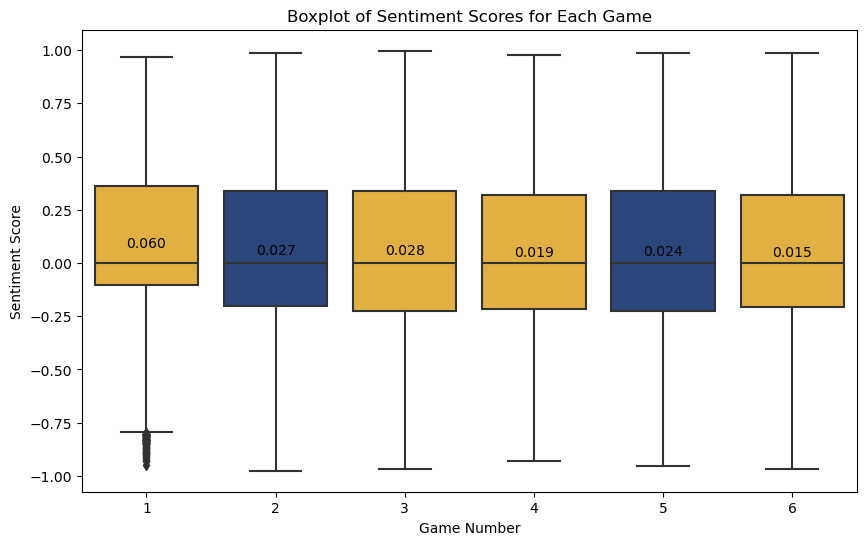

In [112]:
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

colors = ['#FDB927', '#1D428A', '#FDB927','#FDB927', '#1D428A','#FDB927' ]


# Create a boxplot using Seaborn
sns.boxplot(data=combined_df, x='game_number', y='compound_ss', palette = colors)

mean_scores = combined_df.groupby('game_number')['compound_ss'].mean()

for i, mean_score in enumerate(mean_scores):
    plt.text(i, mean_score, f'{mean_score:.3f}', ha='center', va='bottom', fontweight='ultralight')
# Set plot labels and title

plt.xlabel('Game Number')
plt.ylabel('Sentiment Score')
plt.title('Boxplot of Sentiment Scores for Each Game')

# Show the plot
plt.show()

In [71]:
mean_scores = combined_df.groupby('game_number')['ss'].mean()
mean_scores

game_number
1    0.059774
2    0.027192
3    0.027719
4    0.018963
5    0.023579
6    0.014924
Name: ss, dtype: float64